In [90]:
import pandas as pd
import matplotlib.pyplot as plt

In [91]:
########## Balance mix strategy

In [92]:
busiest_day= pd.read_csv(r'../../results/busiest-day-trips-info.csv', low_memory=False)

In [93]:
# Assuming busiest_day is your dataframe
busiest_day['Route'] = busiest_day['Route'].str.replace(r'\(X\)', '', regex=True) # replace (X)
busiest_day['Route'] = busiest_day['Route'].str.replace('X', '', regex=False) # replace X

In [94]:
### FH High-cap Scenario

In [95]:
h_FH_variables = pd.read_csv(r'../../results/highcap-FH-optimized-variables-with-replacement.csv', low_memory=False)

In [96]:
h_FH_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [97]:
# Extract attributes from h_FH_variables
h_FH_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = h_FH_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
h_FH_variables = h_FH_variables.dropna()
h_FH_variables['Year'] = h_FH_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_FH_variables['Trip'] = h_FH_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from h_FH_coefficients
h_FH_coefficients[['Scenario', 'Year', 'Trip']] = h_FH_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
h_FH_coefficients = h_FH_coefficients.dropna()
h_FH_coefficients['Year'] = h_FH_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
h_FH_variables['Trip'] = h_FH_variables['Trip'].astype(str)
h_FH_coefficients['Trip'] = h_FH_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = h_FH_variables.merge(h_FH_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update h_FH_variables
h_FH_variables = merged_df

In [98]:
# Merge the dataframes on matching values
merged_df = h_FH_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_FH_variables
h_FH_variables = merged_df

h_FH_variables['ServiceDateTime_min'] = pd.to_datetime(h_FH_variables['ServiceDateTime_min'])
h_FH_variables['ServiceDateTime_max'] = pd.to_datetime(h_FH_variables['ServiceDateTime_max'])
#h_FH_variables['Value'] = pd.to_numeric(h_FH_variables['Value'])

In [99]:
h_FH_variables.to_csv(r'../../results/highcap-FH-optimized-variables-aggregated-with-replacement.csv', index=False)

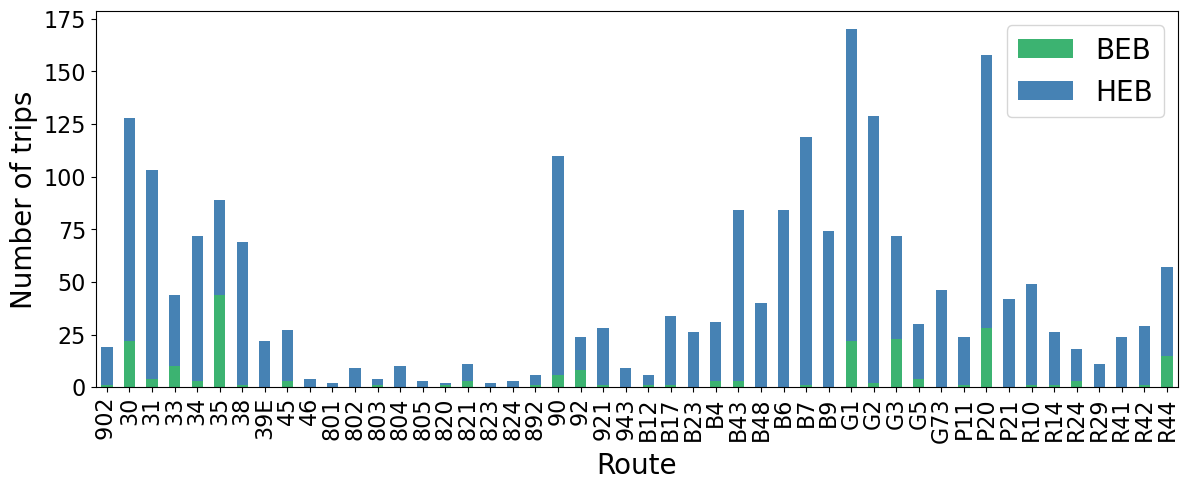

In [100]:
# Filter the dataframe for Year=13 and Value=1
h_FH_variables_filtered = h_FH_variables[(h_FH_variables['Year'] == 12) & (h_FH_variables['Value'] == 1)]
h_FH_variables_filtered = h_FH_variables_filtered[h_FH_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = h_FH_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()

fig.savefig(r'../../figures/h_FH_route_electrification.png', dpi=400)  

plt.show()


In [101]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 10.03%


C:\Users\Mahsa\AppData\Local\Temp\ipykernel_34508\751809084.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pivot_dist = pivot_dist.append(new_row, ignore_index=True)


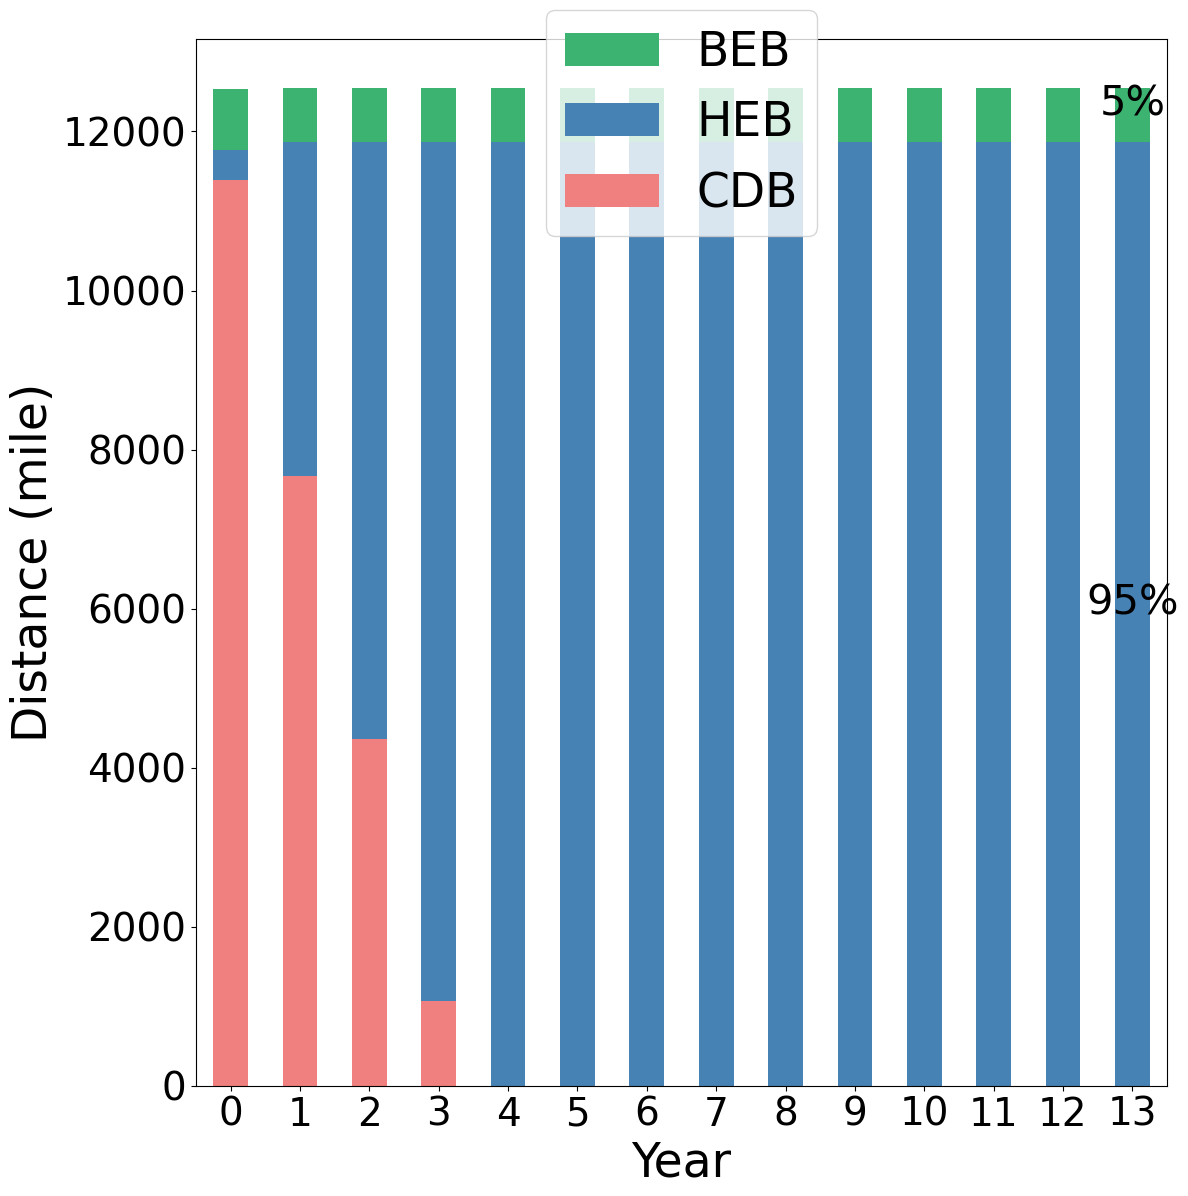

In [102]:
# Sum the 'dist' for each 'Powertrain' and 'Year'
h_FH_variables_values = h_FH_variables[h_FH_variables['Value'] == 1]
sum_dist = h_FH_variables_values.groupby(['Year', 'Powertrain'])['dist'].sum().reset_index()

# Pivot the DataFrame for easier plotting
pivot_dist = sum_dist.pivot(index='Year', columns='Powertrain', values='dist').fillna(0)

# Shift years by one
pivot_dist.reset_index(inplace=True)
pivot_dist['Year'] = pivot_dist['Year'] + 1

# Adding the new row for Year 0 (2022)
new_row = {'Year': 0, 'Powertrain': 'value', 'CDB': 11386, 'HEB': 382, 'BEB': 772}
pivot_dist = pivot_dist.append(new_row, ignore_index=True)
    
# Sorting the DataFrame by Year
pivot_dist = pivot_dist.sort_values(by='Year').reset_index(drop=True)

# Setting the 'Year' as the index again if you want
pivot_dist.set_index('Year', inplace=True)

# Reorder the columns
pivot_dist = pivot_dist[['CDB', 'HEB', 'BEB']]

# Compute the percentage for annotation
pivot_percentage = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Define the colors
colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
pivot_dist.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_dist.columns], ax=ax)

# Annotate each bar with the corresponding percentage for the last year only
last_year_idx = len(pivot_dist.index) - 1
total_dist = 0
for j, powertrain in enumerate(pivot_dist.columns):
    percentage = pivot_percentage.loc[pivot_dist.index[last_year_idx], powertrain]
    dist = pivot_dist.loc[pivot_dist.index[last_year_idx], powertrain]
    if dist > 0:
        ax.text(last_year_idx, total_dist + dist / 2, f'{round(percentage)}%', ha='center', color='black', fontsize=30)
    total_dist += dist

# Setting labels, title, and making the fonts larger
plt.xlabel('Year', fontsize=34)
plt.ylabel('Distance (mile)', fontsize=34)
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(r'../../figures/h_FH_milage_electrification.png', dpi=400)

plt.show()

In [103]:
h_FH_variables_y = pd.read_csv(r'../../results/highcap-FH-optimized-variables-with-replacement-y.csv', low_memory=False)

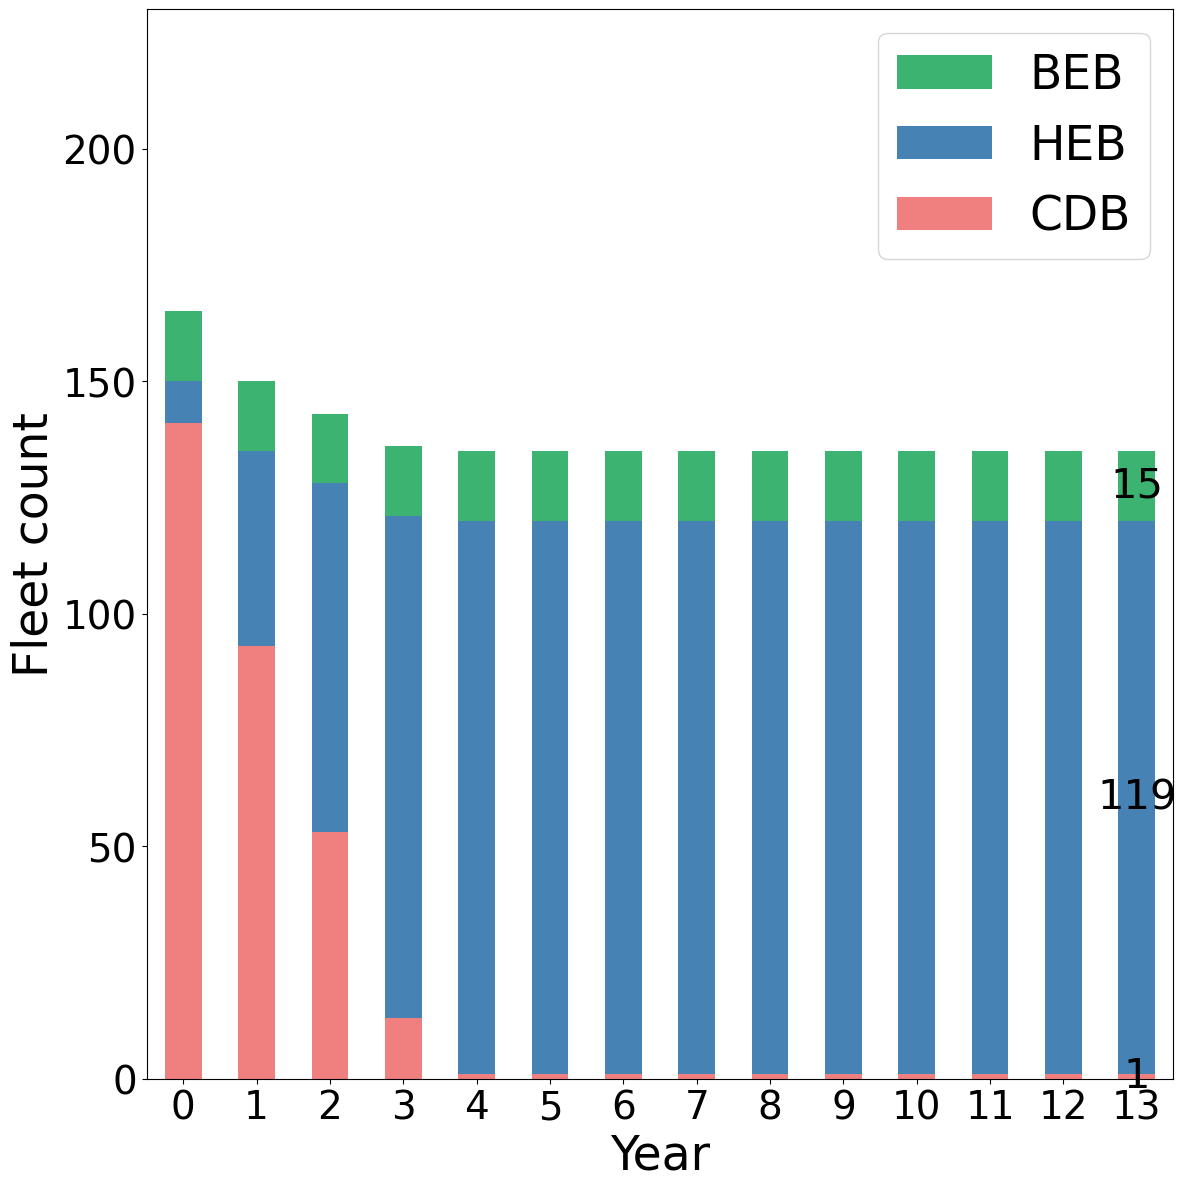

In [104]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = h_FH_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Reorder the columns
grouped_values = grouped_values[['CDB', 'HEB', 'BEB']]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values for the last bar
for container_idx, container in enumerate(ax.containers):
    for rect_idx, rect in enumerate(container):
        if rect_idx == len(container) - 1:  # Annotate only the last bar
            height = rect.get_height()
            ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        ha='center', 
                        va='center',
                        color='black',  
                        fontsize=30)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=34)
ax.set_ylabel('Fleet count', fontsize=34)

# Reverse the order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34)

ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 230)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=28)

plt.tight_layout()

fig.savefig(r'../../figures/h_FH_fleet.png', dpi=400)  

plt.show()


In [105]:
total_sum = (h_FH_variables['Value'] * h_FH_variables['Coefficient']).sum()
print(total_sum)

28174.488473771


In [106]:
### FH Mid-cap Scenario

In [107]:
m_FH_variables = pd.read_csv(r'../../results/midcap-FH-optimized-variables-with-replacement.csv', low_memory=False)

In [108]:
m_FH_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [109]:
# Extract attributes from m_FH_variables
m_FH_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = m_FH_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
m_FH_variables = m_FH_variables.dropna()
m_FH_variables['Year'] = m_FH_variables['Year'].astype(int).copy()
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_FH_variables['Trip'] = m_FH_variables['Trip'].astype(str)
busiest_day['TripKey'] = busiest_day['TripKey'].astype(str)


# Extract attributes from m_FH_coefficients
m_FH_coefficients[['Scenario', 'Year', 'Trip']] = m_FH_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
m_FH_coefficients = m_FH_coefficients.dropna()
m_FH_coefficients['Year'] = m_FH_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
m_FH_variables['Trip'] = m_FH_variables['Trip'].astype(str)
m_FH_coefficients['Trip'] = m_FH_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = m_FH_variables.merge(m_FH_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update m_FH_variables
m_FH_variables = merged_df

In [110]:
# Merge the dataframes on matching values
merged_df = m_FH_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update h_FH_variables
m_FH_variables = merged_df

m_FH_variables['ServiceDateTime_min'] = pd.to_datetime(m_FH_variables['ServiceDateTime_min'])
m_FH_variables['ServiceDateTime_max'] = pd.to_datetime(m_FH_variables['ServiceDateTime_max'])
#h_FH_variables['Value'] = pd.to_numeric(h_FH_variables['Value'])

In [111]:
m_FH_variables.to_csv(r'../../results/midcap-FH-optimized-variables-aggregated-with-replacement.csv', index=False)

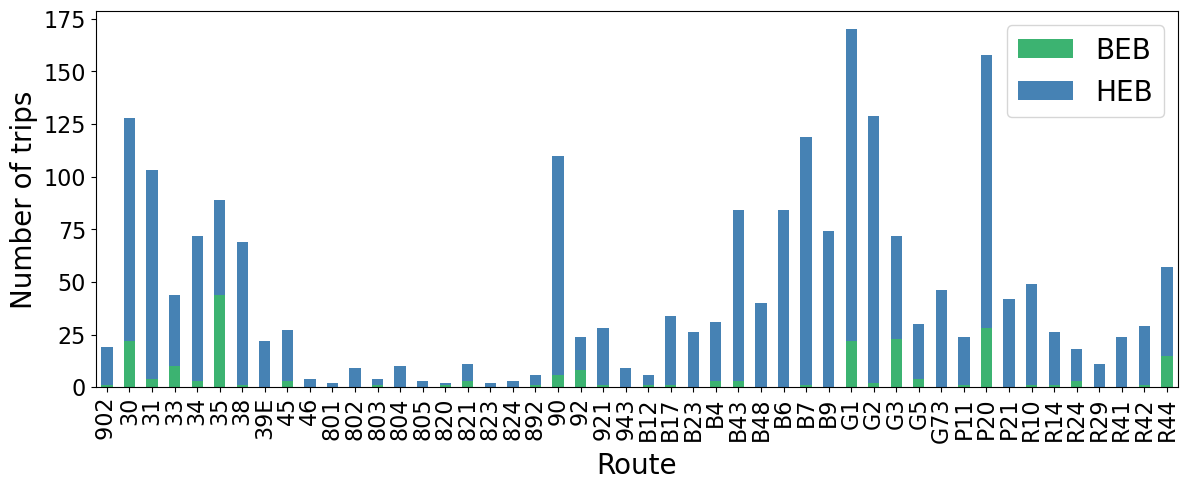

In [112]:
# Filter the dataframe for Year=13 and Value=1
m_FH_variables_filtered = m_FH_variables[(m_FH_variables['Year'] == 12) & (m_FH_variables['Value'] == 1)]
m_FH_variables_filtered = m_FH_variables_filtered[m_FH_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = m_FH_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/m_FH_route_electrification.png', dpi=400)  

plt.show()


In [113]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 10.03%


C:\Users\Mahsa\AppData\Local\Temp\ipykernel_34508\123236719.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pivot_dist = pivot_dist.append(new_row, ignore_index=True)


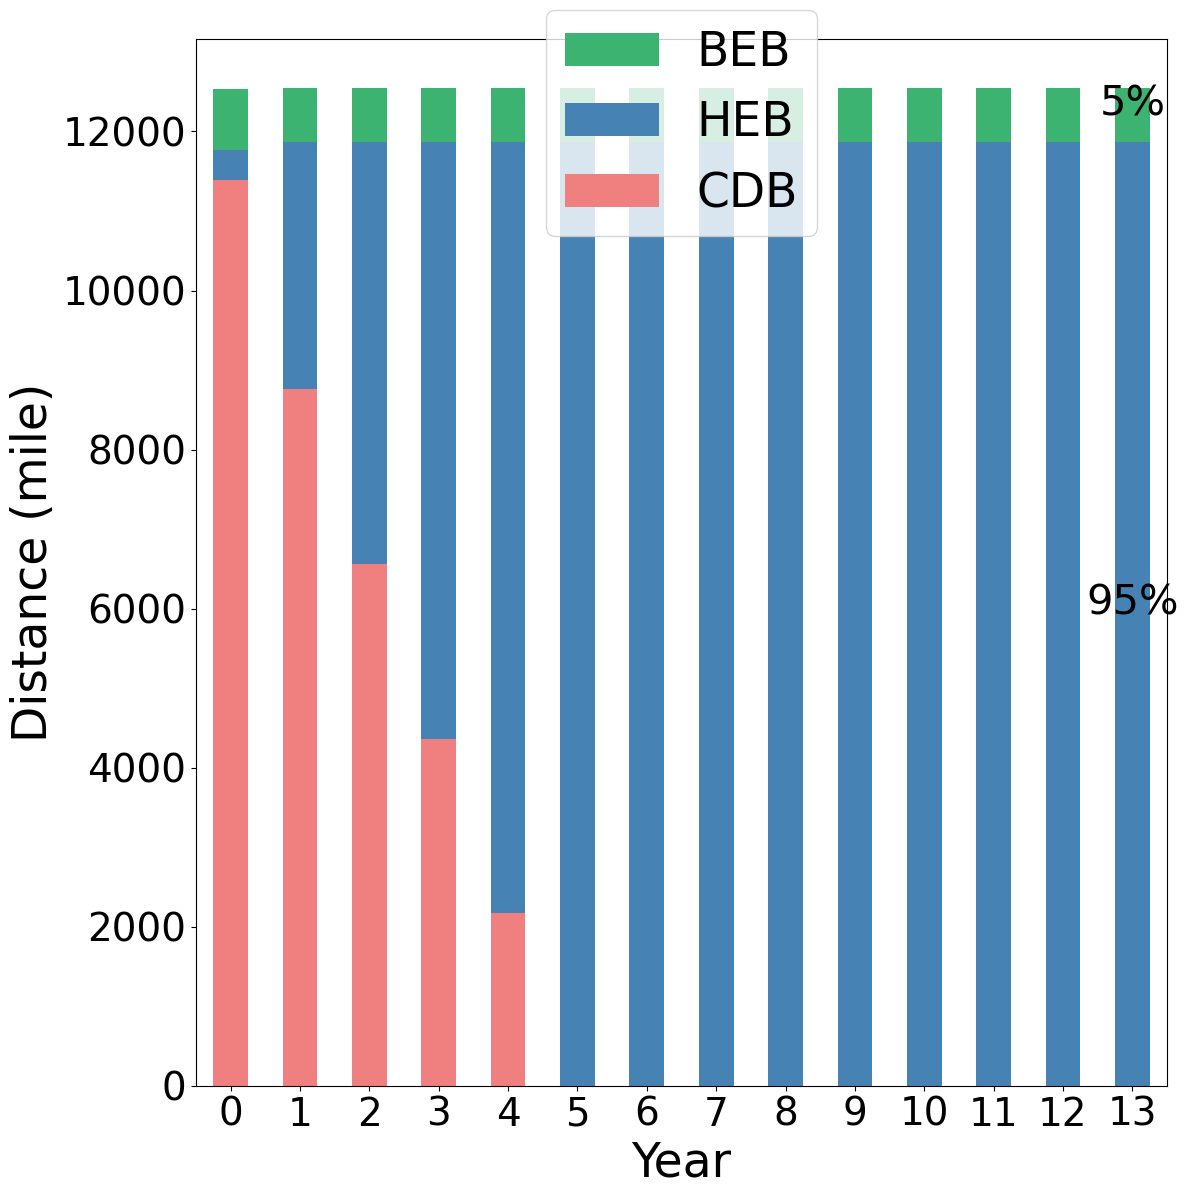

In [114]:
# Sum the 'dist' for each 'Powertrain' and 'Year'
m_FH_variables_values = m_FH_variables[m_FH_variables['Value'] == 1]
sum_dist = m_FH_variables_values.groupby(['Year', 'Powertrain'])['dist'].sum().reset_index()

# Pivot the DataFrame for easier plotting
pivot_dist = sum_dist.pivot(index='Year', columns='Powertrain', values='dist').fillna(0)

# Shift years by one
pivot_dist.reset_index(inplace=True)
pivot_dist['Year'] = pivot_dist['Year'] + 1

# Adding the new row for Year 0 (2022)
new_row = {'Year': 0, 'Powertrain': 'value', 'CDB': 11386, 'HEB': 382, 'BEB': 772}
pivot_dist = pivot_dist.append(new_row, ignore_index=True)
    
# Sorting the DataFrame by Year
pivot_dist = pivot_dist.sort_values(by='Year').reset_index(drop=True)

# Setting the 'Year' as the index again if you want
pivot_dist.set_index('Year', inplace=True)

# Reorder the columns
pivot_dist = pivot_dist[['CDB', 'HEB', 'BEB']]

# Compute the percentage for annotation
pivot_percentage = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Define the colors
colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
pivot_dist.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_dist.columns], ax=ax)

# Annotate each bar with the corresponding percentage for the last year only
last_year_idx = len(pivot_dist.index) - 1
total_dist = 0
for j, powertrain in enumerate(pivot_dist.columns):
    percentage = pivot_percentage.loc[pivot_dist.index[last_year_idx], powertrain]
    dist = pivot_dist.loc[pivot_dist.index[last_year_idx], powertrain]
    if dist > 0:
        ax.text(last_year_idx, total_dist + dist / 2, f'{round(percentage)}%', ha='center', color='black', fontsize=30)
    total_dist += dist

# Setting labels, title, and making the fonts larger
plt.xlabel('Year', fontsize=34)
plt.ylabel('Distance (mile)', fontsize=34)
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(r'../../figures/m_FH_milage_electrification.png', dpi=400)

plt.show()

In [115]:
m_FH_variables_y = pd.read_csv(r'../../results/midcap-FH-optimized-variables-with-replacement-y.csv', low_memory=False)

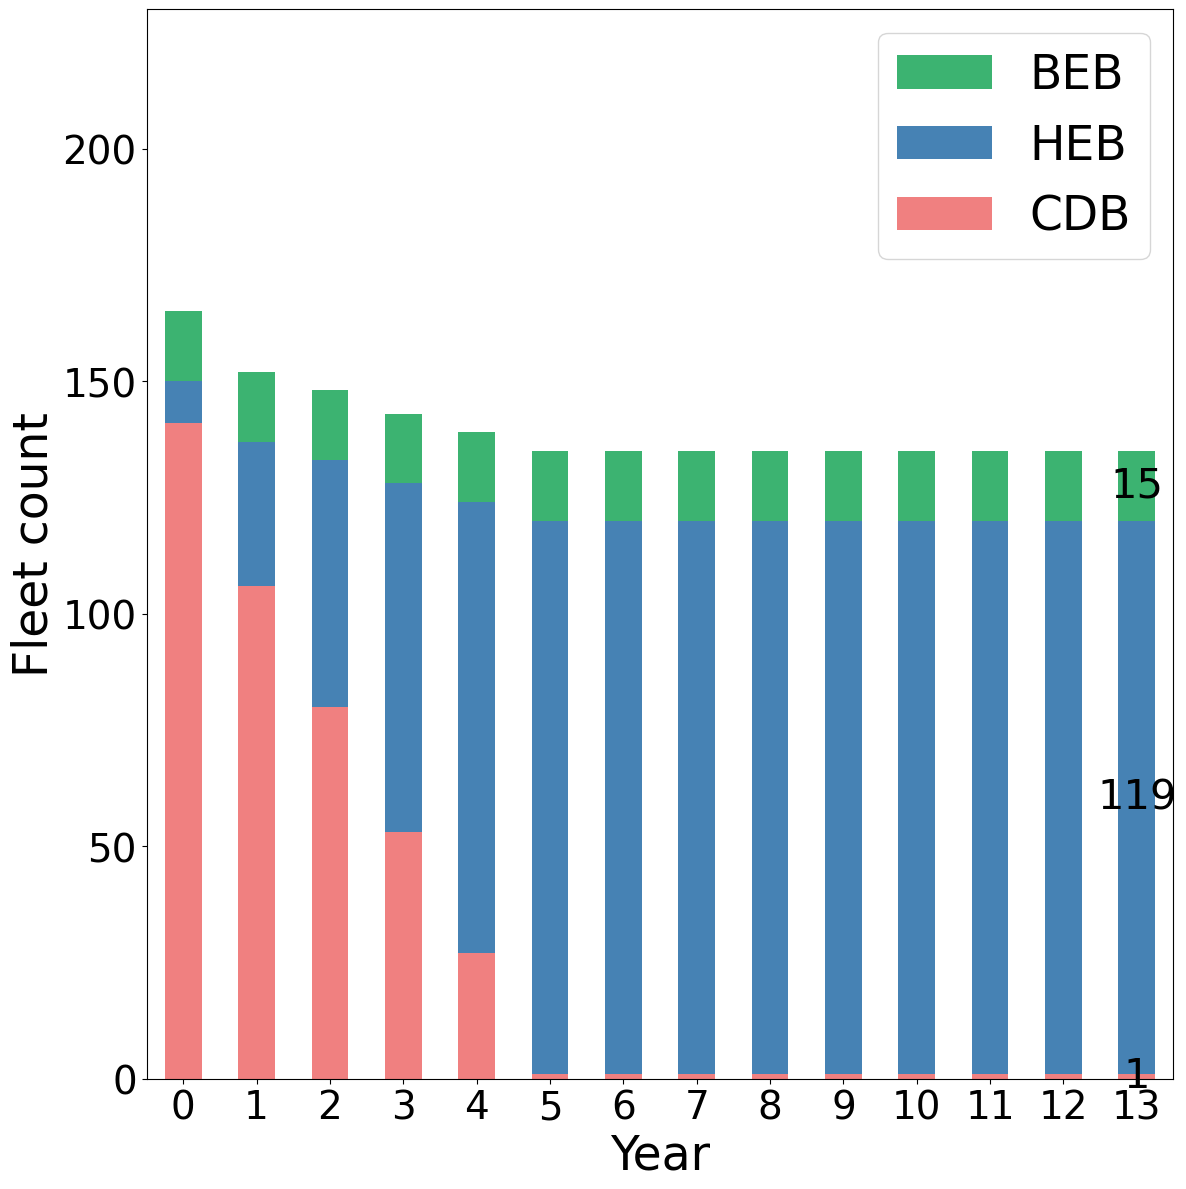

In [116]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = m_FH_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Reorder the columns
grouped_values = grouped_values[['CDB', 'HEB', 'BEB']]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values for the last bar
for container_idx, container in enumerate(ax.containers):
    for rect_idx, rect in enumerate(container):
        if rect_idx == len(container) - 1:  # Annotate only the last bar
            height = rect.get_height()
            ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        ha='center', 
                        va='center',
                        color='black',  
                        fontsize=30)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=34)
ax.set_ylabel('Fleet count', fontsize=34)

# Reverse the order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34)

ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 230)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=28)

plt.tight_layout()

fig.savefig(r'../../figures/m_FH_fleet.png', dpi=400)  

plt.show()


In [117]:
total_sum = (m_FH_variables['Value'] * m_FH_variables['Coefficient']).sum()
print(total_sum)

28647.31308654


In [118]:
### FH Low-cap Scenario

In [119]:
l_FH_variables = pd.read_csv(r'../../results/lowcap-FH-optimized-variables-with-replacement.csv', low_memory=False)

In [120]:
l_FH_coefficients = pd.read_csv(r'../../results/optimization-coefficients.csv', low_memory=False)

In [121]:
# Extract attributes from l_FH_variables
l_FH_variables[['Powertrain', 'Scenario', 'Year', 'Trip']] = l_FH_variables['Variable'].str.extract(r'x_(\w+)\[(\w+-cap),(\d+),(\d+)\]')
l_FH_variables = l_FH_variables.dropna()
l_FH_variables['Year'] = l_FH_variables['Year'].astype(int)
# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_FH_variables['Trip'] = l_FH_variables['Trip'].astype(str)

# Extract attributes from h_FH_coefficients
l_FH_coefficients[['Scenario', 'Year', 'Trip']] = l_FH_coefficients['Variable'].str.extract(r"\('(\w+-\w+)', (\d+), (\d+)\)")
l_FH_coefficients = l_FH_coefficients.dropna()
l_FH_coefficients['Year'] = l_FH_coefficients['Year'].astype(int)

# Convert 'Trip' columns to string type for both dataframes (ensure consistency)
l_FH_variables['Trip'] = l_FH_variables['Trip'].astype(str)
l_FH_coefficients['Trip'] = l_FH_coefficients['Trip'].astype(str)

# Merge the dataframes on matching values
merged_df = l_FH_variables.merge(l_FH_coefficients[['Powertrain','Year', 'Trip', 'Coefficient']],
                                on=['Powertrain','Year', 'Trip',],
                                how='left')

# Update l_FH_variables
l_FH_variables = merged_df

In [122]:
# Merge the dataframes on matching values
merged_df = l_FH_variables.merge(busiest_day[['TripKey', 'Route', 'Stop_first', 'Stop_last', 'ServiceDateTime_min', 'ServiceDateTime_max', 'dist']], 
                                 left_on='Trip', 
                                 right_on='TripKey', 
                                 how='left')

# Drop the TripKey column if not needed
merged_df.drop(columns='TripKey', inplace=True)

# Update l_FH_variables
l_FH_variables = merged_df

l_FH_variables['ServiceDateTime_min'] = pd.to_datetime(l_FH_variables['ServiceDateTime_min'])
l_FH_variables['ServiceDateTime_max'] = pd.to_datetime(l_FH_variables['ServiceDateTime_max'])

In [123]:
l_FH_variables.to_csv(r'../../results/lowcap-FH-optimized-variables-aggregated-with-replacement.csv', index=False)

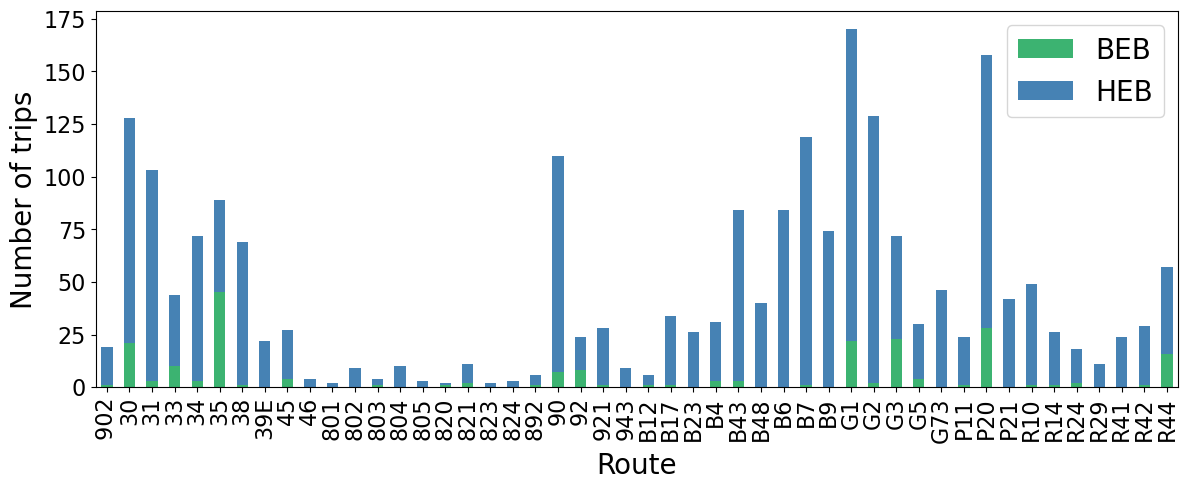

In [124]:
# Filter the dataframe for Year=13 and Value=1
l_FH_variables_filtered = l_FH_variables[(l_FH_variables['Year'] == 12) & (l_FH_variables['Value'] == 1)]
l_FH_variables_filtered = l_FH_variables_filtered[l_FH_variables_filtered['Route'] != '9999']

# Group by Route and Powertrain to count unique trips
grouped_trips = l_FH_variables_filtered.groupby(['Route', 'Powertrain'])['Trip'].nunique().unstack(fill_value=0)

# Plot
# Create a figure and a set of subplots with larger size
fig, ax = plt.subplots(figsize=(12, 5))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_trips.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_trips.columns], ax=ax)

# Annotate with BEB percentages
for index, (route, row) in enumerate(grouped_trips.iterrows()):
    total = row.sum()
    BEB_count = row.get('BEB', 0)
    percentage = (BEB_count / total) * 100
    #ax.text(index, row['CDB'] + row['HEB'] + (0.5 * BEB_count), f'{percentage:.1f}%', ha='center', color='white', fontsize=10)
    
# Set the title and labels with larger font sizes
ax.set_xlabel('Route', fontsize=20)
ax.set_ylabel('Number of trips', fontsize=20)
ax.legend(fontsize=20)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=16)

plt.tight_layout()
fig.savefig(r'../../figures/l_FH_route_electrification.png', dpi=400)  

plt.show()


In [125]:
# Compute the total BEB counts and total trips
total_BEB_counts = grouped_trips['BEB'].sum()
total_trips = grouped_trips.sum(axis=1).sum()

# Calculate average %BEB across all routes
average_percentage_BEB = (total_BEB_counts / total_trips) * 100

print(f"Average %BEB across all routes: {average_percentage_BEB:.2f}%")


Average %BEB across all routes: 10.03%


C:\Users\Mahsa\AppData\Local\Temp\ipykernel_34508\1779783688.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pivot_dist = pivot_dist.append(new_row, ignore_index=True)


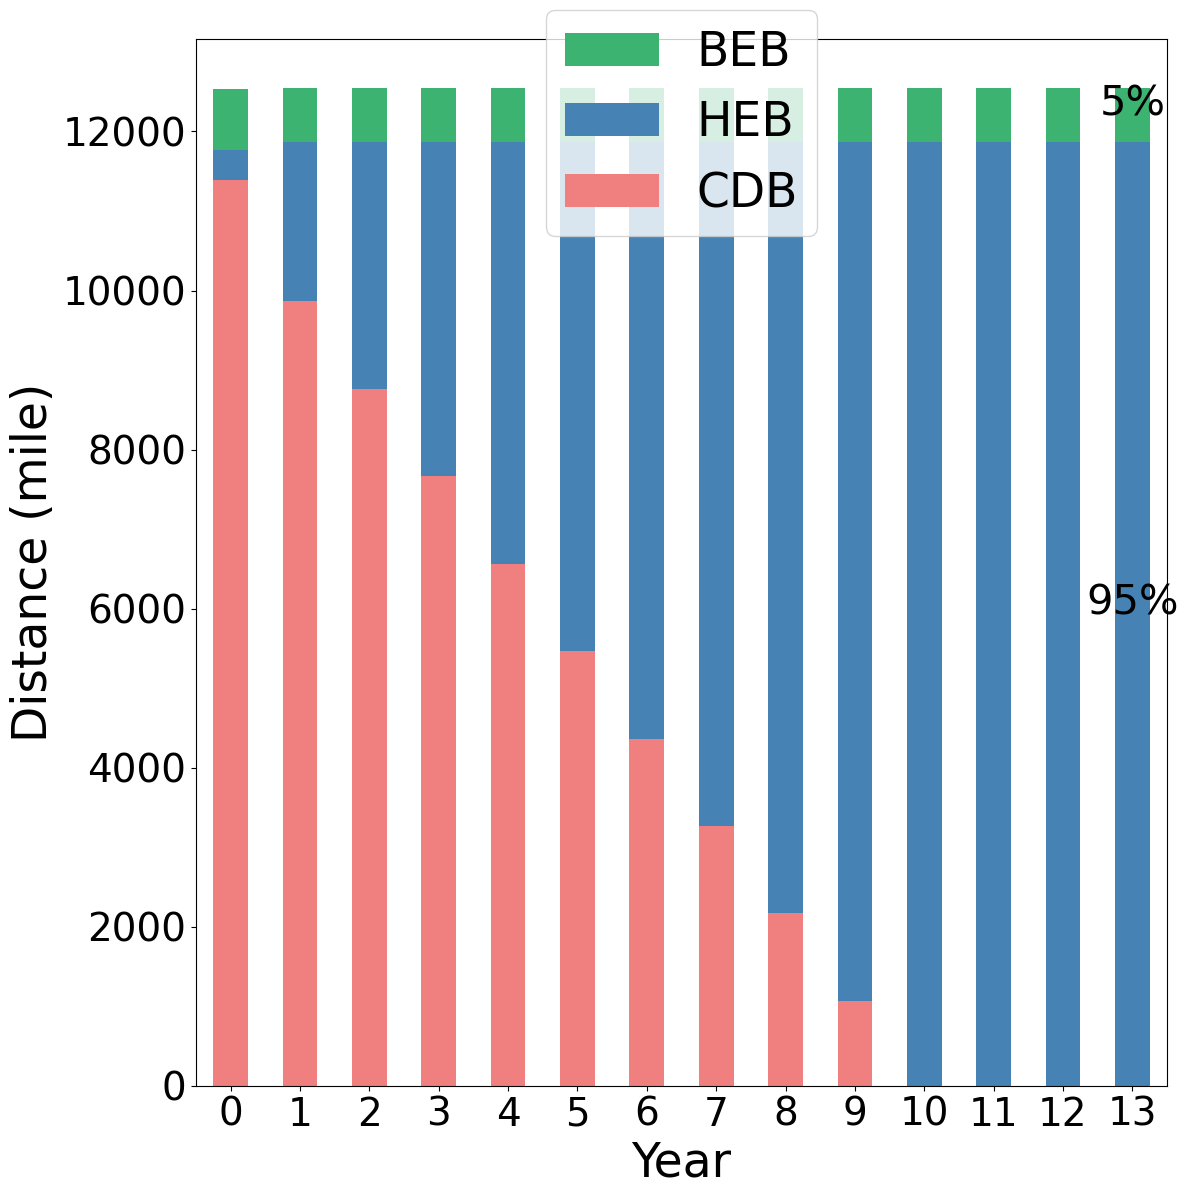

In [126]:
# Sum the 'dist' for each 'Powertrain' and 'Year'
l_FH_variables_values = l_FH_variables[l_FH_variables['Value'] == 1]
sum_dist = l_FH_variables_values.groupby(['Year', 'Powertrain'])['dist'].sum().reset_index()

# Pivot the DataFrame for easier plotting
pivot_dist = sum_dist.pivot(index='Year', columns='Powertrain', values='dist').fillna(0)

# Shift years by one
pivot_dist.reset_index(inplace=True)
pivot_dist['Year'] = pivot_dist['Year'] + 1

# Adding the new row for Year 0 (2022)
new_row = {'Year': 0, 'Powertrain': 'value', 'CDB': 11386, 'HEB': 382, 'BEB': 772}
pivot_dist = pivot_dist.append(new_row, ignore_index=True)
    
# Sorting the DataFrame by Year
pivot_dist = pivot_dist.sort_values(by='Year').reset_index(drop=True)

# Setting the 'Year' as the index again if you want
pivot_dist.set_index('Year', inplace=True)

# Reorder the columns
pivot_dist = pivot_dist[['CDB', 'HEB', 'BEB']]

# Compute the percentage for annotation
pivot_percentage = pivot_dist.div(pivot_dist.sum(axis=1), axis=0) * 100

# Define the colors
colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}

# Create the plot
fig, ax = plt.subplots(figsize=(12, 12))
pivot_dist.plot(kind='bar', stacked=True, color=[colors[col] for col in pivot_dist.columns], ax=ax)

# Annotate each bar with the corresponding percentage for the last year only
last_year_idx = len(pivot_dist.index) - 1
total_dist = 0
for j, powertrain in enumerate(pivot_dist.columns):
    percentage = pivot_percentage.loc[pivot_dist.index[last_year_idx], powertrain]
    dist = pivot_dist.loc[pivot_dist.index[last_year_idx], powertrain]
    if dist > 0:
        ax.text(last_year_idx, total_dist + dist / 2, f'{round(percentage)}%', ha='center', color='black', fontsize=30)
    total_dist += dist

# Setting labels, title, and making the fonts larger
plt.xlabel('Year', fontsize=34)
plt.ylabel('Distance (mile)', fontsize=34)
plt.xticks(fontsize=28, rotation=0)
plt.yticks(fontsize=28)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34, loc='upper center', bbox_to_anchor=(0.5, 1.05))

plt.tight_layout()

fig.savefig(r'../../figures/l_FH_milage_electrification.png', dpi=400)

plt.show()

In [127]:
l_FH_variables_y = pd.read_csv(r'../../results/lowcap-FH-optimized-variables-with-replacement-y.csv', low_memory=False)

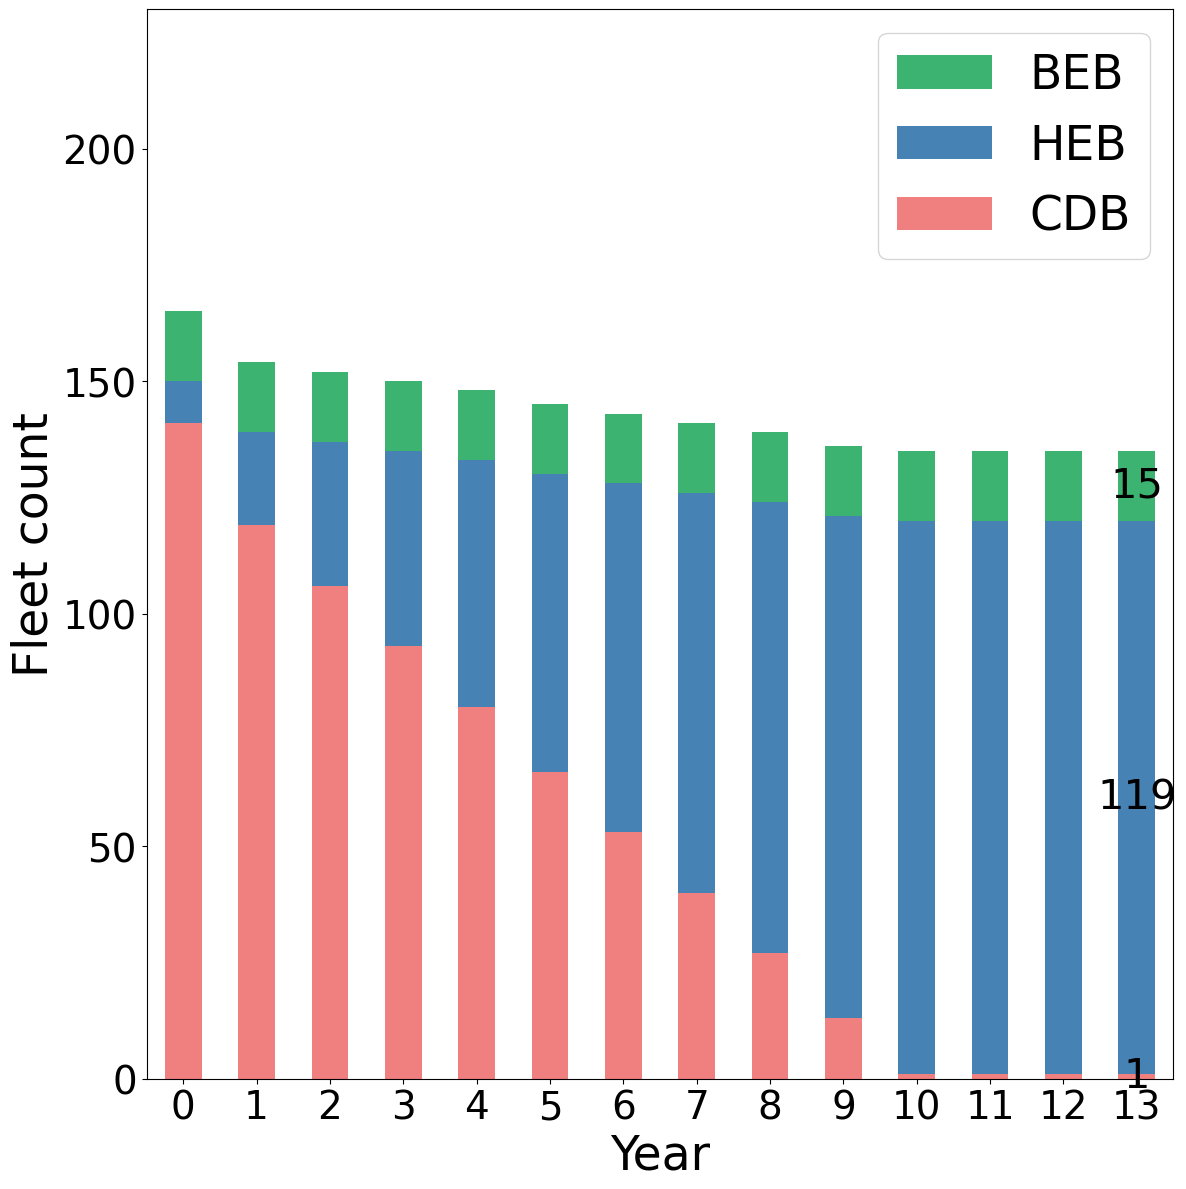

In [128]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by Year and Powertrain to sum up the Value
grouped_values = l_FH_variables_y.groupby(['Year', 'Powertrain'])['Value'].sum().unstack(fill_value=0)

# Reorder the columns
grouped_values = grouped_values[['CDB', 'HEB', 'BEB']]

# Plot
fig, ax = plt.subplots(figsize=(12, 12))

colors = {'CDB': 'lightcoral', 'HEB': 'steelblue', 'BEB': 'mediumseagreen'}
ax = grouped_values.plot(kind='bar', stacked=True, color=[colors[col] for col in grouped_values.columns], ax=ax)

# Annotate bars with the segment values for the last bar
for container_idx, container in enumerate(ax.containers):
    for rect_idx, rect in enumerate(container):
        if rect_idx == len(container) - 1:  # Annotate only the last bar
            height = rect.get_height()
            ax.annotate(f'{int(height)}',  # Dropped the decimals by converting to int
                        xy=(rect.get_x() + rect.get_width() / 2, rect.get_y() + height / 2),
                        ha='center', 
                        va='center',
                        color='black',  
                        fontsize=30)

# Set the title and labels with larger font sizes
ax.set_xlabel('Year', fontsize=34)
ax.set_ylabel('Fleet count', fontsize=34)

# Reverse the order of legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], fontsize=34)

ax.set_xticklabels(grouped_values.index, rotation=0)
ax.set_ylim(0, 230)

# Increase the font size for tick labels
ax.tick_params(axis='both', labelsize=28)

plt.tight_layout()

fig.savefig(r'../../figures/l_FH_fleet.png', dpi=400)  

plt.show()


In [129]:
total_sum = (l_FH_variables['Value'] * l_FH_variables['Coefficient']).sum()
print(total_sum)

30100.083366526003


In [130]:
# Calculate sum for each Year for each DataFrame
h_FH_variables['Result'] = h_FH_variables['Value'] * h_FH_variables['Coefficient']
h_FH_sum = h_FH_variables.groupby('Year')['Result'].sum().reset_index()

m_FH_variables['Result'] = m_FH_variables['Value'] * m_FH_variables['Coefficient']
m_FH_sum = m_FH_variables.groupby('Year')['Result'].sum().reset_index()

l_FH_variables['Result'] = l_FH_variables['Value'] * l_FH_variables['Coefficient']
l_FH_sum = l_FH_variables.groupby('Year')['Result'].sum().reset_index()

# Add Scenario and Strategy columns
h_FH_sum['Scenario'] = 'h'
h_FH_sum['Strategy'] = 'FH'

m_FH_sum['Scenario'] = 'm'
m_FH_sum['Strategy'] = 'FH'

l_FH_sum['Scenario'] = 'l'
l_FH_sum['Strategy'] = 'FH'

# Concatenate the DataFrames
final_df = pd.concat([h_FH_sum, m_FH_sum, l_FH_sum])

# Rearrange the columns
final_df = final_df[['Year', 'Result', 'Scenario', 'Strategy']]
final_df.to_csv(r'../../results/diesel-FH-with-replacement.csv', index=False)

In [131]:
final_df

,Year,Result,Scenario,Strategy
0,0,2535.826889,h,FH
1,1,2319.316865,h,FH
2,2,2151.389396,h,FH
3,3,2116.767773,h,FH
4,4,2116.767773,h,FH
5,5,2116.767773,h,FH
6,6,2116.767773,h,FH
7,7,2116.767773,h,FH
8,8,2116.767773,h,FH
9,9,2116.837171,h,FH
